<a href="https://colab.research.google.com/github/hatttruong/fastai-playbook/blob/main/05_from_scratch_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Linear model and neural net from scratch

### Download data

In [4]:
# !pip install kaggle
#

# DO THE FOLLOWING STEPS TO AVOID ERROR "Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method."
# !mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
api_token = {"username":"hatruong","key":""}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [5]:
import os
from pathlib import Path
import zipfile
import kaggle

In [6]:
# download data from Kaggle
path = Path("titanic")
if not path.exists():
    # kaggle.api.competition_leaderboard_cli(str(path))
    !kaggle competitions download -c titanic --force
    zipfile.ZipFile(f'{path}.zip').extractall(path)

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 46.9MB/s]


### Setup

In [7]:
import torch
import numpy as np
import pandas as pd

np.set_printoptions(linewidth=140)
pd.set_option('display.width', 140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)

### Clean Data

In [8]:
df = pd.read_csv(path/'train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [35]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [36]:
modes = df.mode()#.iloc[0]
modes

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3.0,"Abbing, Mr. Anthony",male,24.0,0.0,0.0,1601,8.05,B96 B98,S
1,2,NaN,NaN,"Abbott, Mr. Rossmore Edward",NaN,NaN,NaN,NaN,347082,NaN,C23 C25 C27,NaN
2,3,NaN,NaN,"Abbott, Mrs. Stanton (Rosa Hunt)",NaN,NaN,NaN,NaN,CA. 2343,NaN,G6,NaN
3,4,NaN,NaN,"Abelson, Mr. Samuel",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,NaN,"Abelson, Mrs. Samuel (Hannah Wizosky)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,NaN,NaN,"de Mulder, Mr. Theodore",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
887,888,NaN,NaN,"de Pelsmaeker, Mr. Alfons",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
888,889,NaN,NaN,"del Carlo, Mr. Sebastiano",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
889,890,NaN,NaN,"van Billiard, Mr. Austin Blyler",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Note: Read more about iloc & loc at https://www.shanelynn.ie/pandas-iloc-loc-select-rows-and-columns-dataframe/

In [9]:
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [10]:
df.fillna(modes, inplace=True)
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [39]:
df.describe(include=(np.number))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<Axes: >

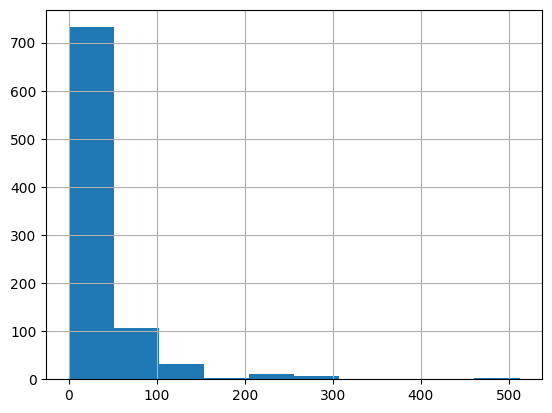

In [40]:
df['Fare'].hist()

<Axes: >

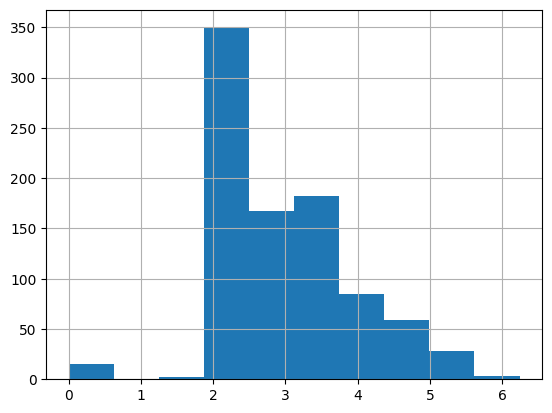

In [11]:
#
df['LogFare'] = np.log(df['Fare'] + 1)
df['LogFare'].hist()

In [14]:
sorted(df['Pclass'].unique())

[1, 2, 3]

In [12]:
df.describe(include=(object))

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


In [15]:
# one-hot vector for categorical columns
df = pd.get_dummies(df, columns=['Sex', 'Pclass', 'Embarked'])


In [16]:
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [17]:
added_columns = ['Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3',
                 'Embarked_C', 'Embarked_Q', 'Embarked_S']
df[added_columns].head()

,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,0,1,0,0,1,0,0,1
1,1,0,1,0,0,1,0,0
2,1,0,0,0,1,0,0,1
3,1,0,1,0,0,0,0,1
4,0,1,0,0,1,0,0,1


### Prepare Tensor

In [18]:
from torch import tensor

In [19]:
t_dep = tensor(df.Survived)

In [20]:
indep_cols = ['Age', 'SibSp', 'Parch', 'LogFare'] + added_columns
indep_cols

['Age',
 'SibSp',
 'Parch',
 'LogFare',
 'Sex_female',
 'Sex_male',
 'Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S']

In [24]:
t_indep = tensor(df[indep_cols].values, dtype=torch.float)
t_indep

tensor([[22.0000,  1.0000,  0.0000,  2.1102,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [38.0000,  1.0000,  0.0000,  4.2806,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [26.0000,  0.0000,  0.0000,  2.1889,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  1.0000,  0.0000,  3.9908,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  0.0000,  0.0000,  2.2028,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [24.0000,  0.0000,  0.0000,  2.2469,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
        [54.0000,  0.0000,  0.0000,  3.9677,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        ...,
        [25.0000,  0.0000,  0.0000,  2.0857,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [39.0000,  0.0000,  5.0000,  3.4054

In [25]:
t_indep.shape

torch.Size([891, 12])

In [26]:
len(t_indep.shape) # rank of tensor
# vector is rank 1, matrix is rank 2, scala is rank zero

2

## Setup a linear model